## Load original dataset

In [1]:
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()

## Map UniProt IDs to CATH Ids

The file containign the map from UniProt + pdb to CATH id can be found here:  https://www.ebi.ac.uk/pdbe/docs/sifts/quick.html

Knowing CATH id it is possible to use their API to obtain informations abbout cath superfamily. Hower the API doesn't always work. For example, consider retrieving infos about `2cubA00`: from the CATH website it is possible to see this entry but the API returns an error http://www.cathdb.info/version/v4_1_0/api/rest/domain_summary/2cubA00

For this reason we had to download a file from CATH containing all the informations about superfamilies: the file is called `cath-b-newest-all.gz` and it can be found here http://cathdb.info/wiki?id=data:index#cath_daily_snapshot.

In [2]:
import pandas as pd
import gzip

with gzip.open('../../data/pdb_chain_cath_uniprot.tsv.gz') as f:
    # skip first row since it cotains only metadata
    df = pd.read_csv(f, sep='\t', header=1)

In [3]:
# drop entries relative to sequences not found in our original dataset
df = df.loc[df['SP_PRIMARY'].isin(dataset)]
df.head()

,PDB,CHAIN,SP_PRIMARY,CATH_ID
213,1a07,A,P12931,1a07A00
214,1a07,B,P12931,1a07B00
215,1a08,A,P12931,1a08A00
216,1a08,B,P12931,1a08B00
217,1a09,A,P12931,1a09A00


In [4]:
num_unique_sequences = df['SP_PRIMARY'].nunique()
print('The original dataset contains {} sequences'.format(len(dataset)))
print('There are {} unique sequences in the UNIPROT to CATH ID dataset'.format(num_unique_sequences))

The original dataset contains 92 sequences
There are 55 unique sequences in the UNIPROT to CATH ID dataset


In [5]:
with gzip.open('../../data/cath-b-newest-all.gz') as f:
    cath_classification = pd.read_csv(
        f, sep=' ', usecols=[0,2], 
        header=None, names=['CATH_ID', 'superfamily']
    )
cath_classification.head()

,CATH_ID,superfamily
0,101mA00,1.10.490.10
1,102lA00,1.10.530.40
2,102mA00,1.10.490.10
3,103lA00,1.10.530.40
4,103mA00,1.10.490.10


In [6]:
## join the two dataframes and retrieve informations about class, topology and architectures
results_dataframe = cath_classification.set_index('CATH_ID') \
                        .join(df.set_index('CATH_ID')) \
                        .dropna(how = 'any')

# parse superfamily column
results_dataframe['topology'] = results_dataframe['superfamily'] \
                                    .apply(lambda sf: ".".join(sf.split('.')[:-1]))

results_dataframe['architecture'] = results_dataframe['superfamily'] \
                                    .apply(lambda sf: ".".join(sf.split('.')[:-2]))

results_dataframe['class'] = results_dataframe['superfamily'] \
                                    .apply(lambda sf: sf.split('.')[0])

results_dataframe = results_dataframe.loc[:, ['SP_PRIMARY', 'superfamily', 
                                              'topology', 'architecture', 'class']]
results_dataframe.head()

,SP_PRIMARY,superfamily,topology,architecture,class
CATH_ID,,,,,
1a07A00,P12931,3.30.505.10,3.30.505,3.30,3
1a07B00,P12931,3.30.505.10,3.30.505,3.30,3
1a08A00,P12931,3.30.505.10,3.30.505,3.30,3
1a08B00,P12931,3.30.505.10,3.30.505,3.30,3
1a09A00,P12931,3.30.505.10,3.30.505,3.30,3


In [7]:
def get_statistics(df, column):
    print('There are {} unique {}'.format(
        results_dataframe.groupby(column)[column].nunique().shape[0],
        column
    ))
    
    print('\nNumber of sequences where a certain {} appears:'.format(column))
    sequences_with_domain = results_dataframe.groupby(column)['SP_PRIMARY'] \
        .unique().apply(lambda x: len(x)).sort_values(ascending=False)
    print(sequences_with_domain.head())
    
    print("\nNumber of {} per sequence".format(column))
    domains_per_sequence = results_dataframe.groupby('SP_PRIMARY')[column] \
        .unique().apply(lambda x: len(x)).sort_values(ascending=False)
    print(domains_per_sequence.head())
    
    return {'domain_abundance': sequences_with_domain, 'num_domains_per_sequence': domains_per_sequence}

In [8]:
stat_superfamily = get_statistics(results_dataframe, 'superfamily')

There are 21 unique superfamily

Number of sequences where a certain superfamily appears:
superfamily
3.30.505.10    44
2.30.30.40     24
1.10.510.10    14
3.30.200.20    14
2.30.29.30      9
Name: SP_PRIMARY, dtype: int64

Number of superfamily per sequence
SP_PRIMARY
Q06187    5
P00519    5
P15498    5
P07332    5
Q08881    4
Name: superfamily, dtype: int64


In [9]:
stat_topology = get_statistics(results_dataframe, 'topology')

There are 21 unique topology

Number of sequences where a certain topology appears:
topology
3.30.505    44
2.30.30     24
1.10.510    14
3.30.200    14
2.30.29      9
Name: SP_PRIMARY, dtype: int64

Number of topology per sequence
SP_PRIMARY
Q06187    5
P00519    5
P15498    5
P07332    5
Q08881    4
Name: topology, dtype: int64


In [10]:
stat_architecture = get_statistics(results_dataframe, 'architecture')

There are 8 unique architecture

Number of sequences where a certain architecture appears:
architecture
3.30    46
2.30    32
1.10    25
1.20     4
3.10     3
Name: SP_PRIMARY, dtype: int64

Number of architecture per sequence
SP_PRIMARY
Q08881    4
P00519    4
P15498    4
Q13322    3
P42684    3
Name: architecture, dtype: int64


In [11]:
stat_class = get_statistics(results_dataframe, 'class')

There are 4 unique class

Number of sequences where a certain class appears:
class
3    46
2    32
1    25
4     1
Name: SP_PRIMARY, dtype: int64

Number of class per sequence
SP_PRIMARY
Q08881    4
P41240    3
P07948    3
P27986    3
P20936    3
Name: class, dtype: int64


In [12]:
# labels for some of our entries.
dic_name = {
    '3.30.505.10': 'SH2 domain',
    '3.30': '2-Layer\n Sandwich',
    '3': 'Alpha Beta',   
    '3.10': 'Roll',
    '3.90': 'Alpha-Beta\n Complex',
    '2.30.30.40': 'SH3 domain',
    '2.30': 'Roll',
    '2': 'Mainly Beta',   
    '1.10.510.10': 'Transferase\n domain 1',
    '1.10': 'Orthogonal\n Bundle', 
    '1.20': 'Up-down\n Bundle',
    '1': 'Mainly Alpha',     
    '3.30.200.20': 'Phosphorylase\n Kinase domain 1',
    '2.30.29.30': 'Phosphotyrosine BD', 
    '1.10.555.10': 'GTPase-GAP domain', 
    '3.30.60.20': '3.30.60.20', 
    '4': 'Few secondary\n structure'
}

In [13]:
# save al figures in this directory
FIGURE_PATH = '../../figures/'

In [14]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

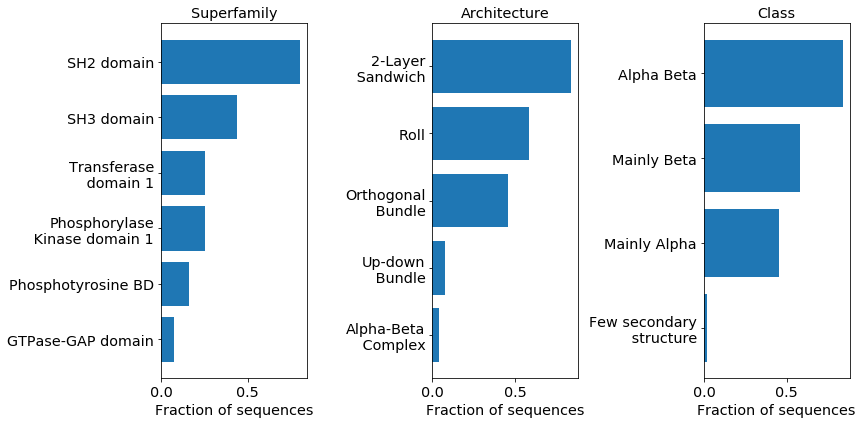

In [15]:
# Fraction of entries where a certain structure has been observed

fig = plt.figure(figsize=(12,6))
plt.subplot(131)
res = stat_superfamily['domain_abundance'][:6]
names = [dic_name[key] for key in res.index]
plt.barh(y=names, width=res.values/num_unique_sequences)
plt.gca().invert_yaxis()
plt.title('Superfamily')
plt.xlabel('Fraction of sequences')

plt.subplot(132)
res = stat_architecture['domain_abundance'][:6]
names = [dic_name[key] for key in res.index]
plt.barh(y=names, width=res.values/num_unique_sequences)
plt.gca().invert_yaxis()
plt.title('Architecture')
plt.xlabel('Fraction of sequences')

plt.subplot(133)
res = stat_class['domain_abundance'][:6]
names = [dic_name[key] for key in res.index]
plt.barh(y=names, width=res.values/num_unique_sequences)
plt.gca().invert_yaxis()
plt.title('Class')
plt.xlabel('Fraction of sequences')

plt.tight_layout()
plt.savefig(FIGURE_PATH + "CATH_classification.pdf")

plt.show()

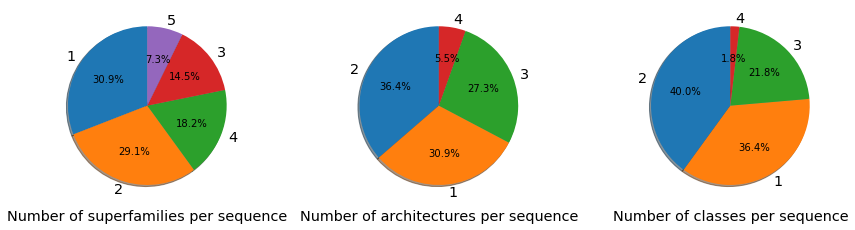

In [16]:
# Number of superfamilies/architectures/classes per sequence

fig = plt.figure(figsize=(12,6))

plt.subplot(131)
res = stat_superfamily['num_domains_per_sequence'].value_counts()
plt.pie(res, labels=res.index,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.xlabel("Number of superfamilies per sequence")

plt.subplot(132)
res = stat_architecture['num_domains_per_sequence'].value_counts()
plt.pie(res, labels=res.index,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.xlabel("Number of architectures per sequence")

plt.subplot(133)
res = stat_class['num_domains_per_sequence'].value_counts()
plt.pie(res, labels=res.index,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.xlabel("Number of classes per sequence")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "NumArchitectures_pie.pdf")
plt.show()

## CATH API

To obtain the superfamily associated to a certain cath id it is possible to use the following function

In [23]:
import urllib
import json

def get_superfamily_id(cath_id):
    """
    CATH api documentation here
    https://github.com/UCLOrengoGroup/cath-api-docs
    """
    url = "http://www.cathdb.info/version/v4_1_0/api/rest/domain_summary/" + cath_id  
    try: 
        response =  urllib.request.urlopen(url).read()
        parsed_json = (json.loads(response.decode()))
        return parsed_json['data']['superfamily_id']
    except:
        print(url)
        return 'Error'

In [24]:
get_superfamily_id('1a07A00')

'3.30.505.10'

In [25]:
# as said, it doesn't always work...
get_superfamily_id('2cubA00')

http://www.cathdb.info/version/v4_1_0/api/rest/domain_summary/2cubA00


'Error'